In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/test_ship_segmentations_v3.csv')
df["EncodedPixels"] += ' '


<AxesSubplot:>

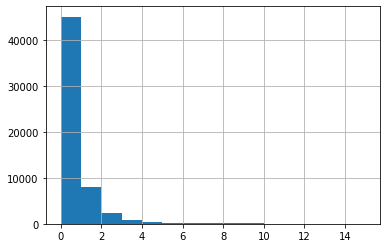

In [3]:
df_by_ships = df.groupby("ImageId", as_index=False).count()
df_by_ships = df_by_ships.rename(columns={"EncodedPixels": "Ships", "ImageId": "Images"})
df_by_ships["Ships"].hist(bins=15)

<BarContainer object of 2 artists>

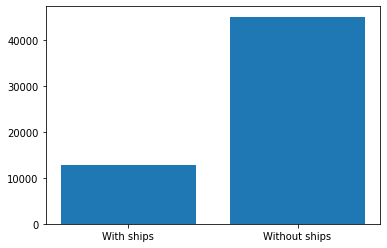

In [8]:
no_ships = len(df_by_ships.loc[df_by_ships["Ships"] == 0])
with_ships = len(df_by_ships) - no_ships
plt.bar(["With ships", "Without ships"], [with_ships, no_ships], width = 0.8)

We can see that the most images(78%) are without any ships so undersampling images without ships would be good idea

In [19]:
def count_pixels_with_ships(s):
    """
    Arguments:
    s - string of Encoded Pixels
    Returns:
    pixels - amount of pixels that contain ship
    """
    if pd.isna(s):
        return 0
    array = np.asarray([int(x) for x in s.split()])
    pixels = sum(array[1::2])
    return pixels

In [30]:
df_pixels = df['EncodedPixels'].map(count_pixels_with_ships)
pixels_with_ships = sum(df_pixels.iloc)
all_pixels = (no_ships+with_ships)*768*768
print(pixels_with_ships/all_pixels*100, "% of pixels contain ship")

0.11329706569478241 % of pixels contain ship


So $\approx$ 99.89% pixels do not contain ship so we cannot rely on accuracy because if our network marks all pixels as "no ship" then it will be 99.89% accurate but that network will be completely useless. That's why we should use some other metrics like IoU or Dice score

Let's look at some of the input images:

In [42]:
no_ship_images = df_by_ships.loc[df_by_ships['Ships'] == 0, 'Images'].sample(n = 4)
images_with_ships = df_by_ships.loc[df_by_ships['Ships'] > 0, 'Images'].sample(n = 4)

Images without ships:

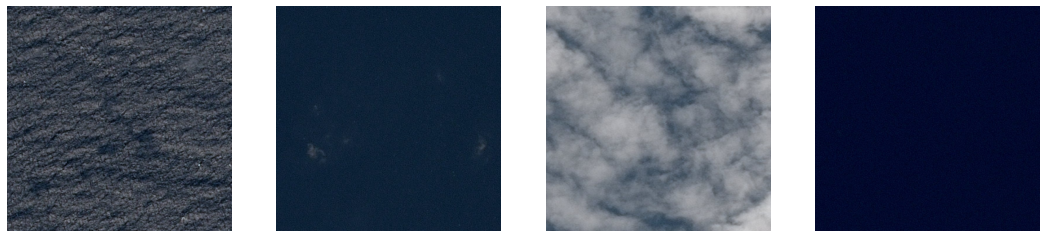

In [43]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(mpimg.imread('data/Images/' + no_ship_images.iloc[0]))
ax2.imshow(mpimg.imread('data/Images/' + no_ship_images.iloc[1]))
ax3.imshow(mpimg.imread('data/Images/' + no_ship_images.iloc[2]))
ax4.imshow(mpimg.imread('data/Images/' + no_ship_images.iloc[3]))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
fig.set_size_inches(18.5, 10.5)

Images with ships:

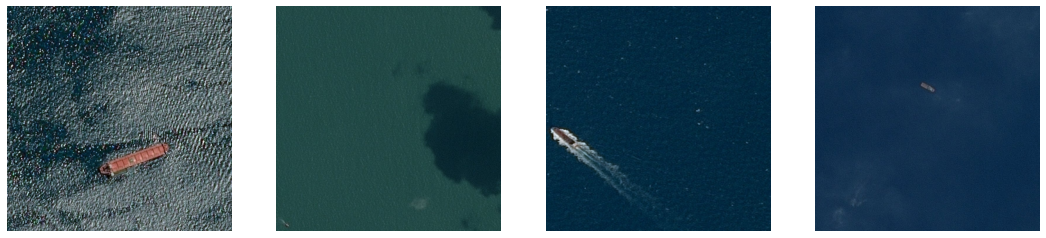

In [44]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(mpimg.imread('data/Images/' + images_with_ships.iloc[0]))
ax2.imshow(mpimg.imread('data/Images/' + images_with_ships.iloc[1]))
ax3.imshow(mpimg.imread('data/Images/' + images_with_ships.iloc[2]))
ax4.imshow(mpimg.imread('data/Images/' + images_with_ships.iloc[3]))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
fig.set_size_inches(18.5, 10.5)

Let's move to model result analysis. I built a pretty simple model with only $\approx$ 9000 parametes. So I ran 16 epochs with no regularization to test if model will overfit and these are results:

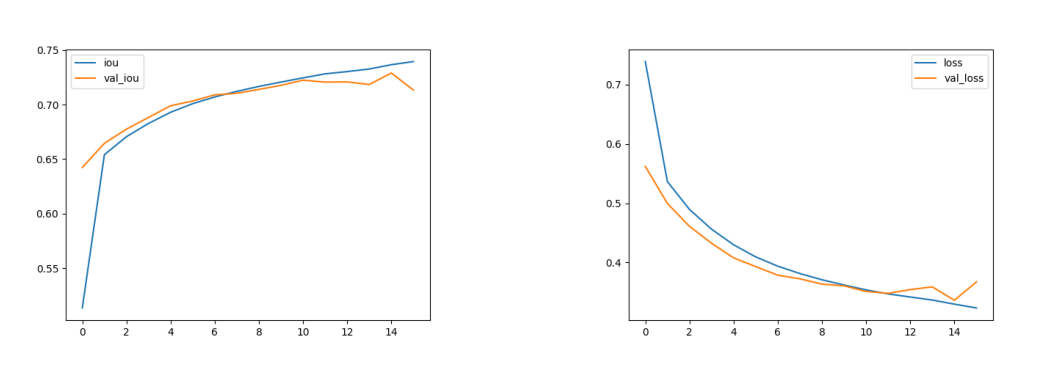

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(mpimg.imread('logs/model_iou_no_dropout.png'))
ax2.imshow(mpimg.imread('logs/model_loss_no_dropout.png'))
ax1.axis('off')
ax2.axis('off')
fig.set_size_inches(18.5, 10.5)


We can see that it started to overfit on later epochs, so I added some dropout regularization and trained model again but now with 24 epochs

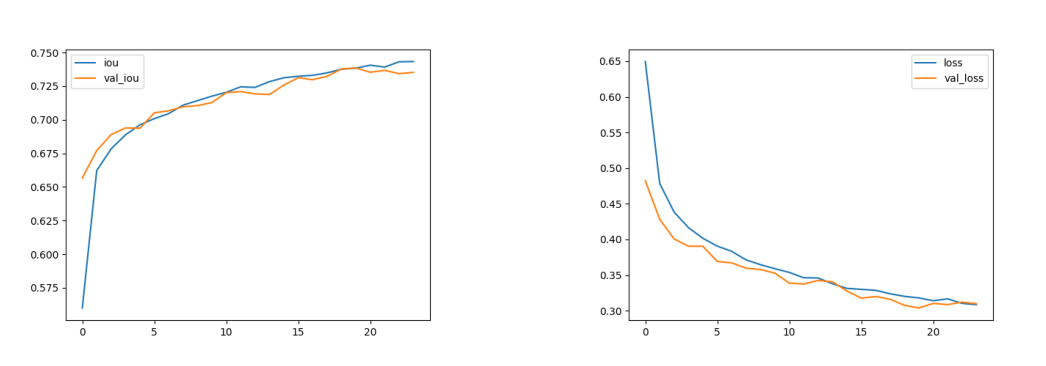

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(mpimg.imread('logs/model_iou.png'))
ax2.imshow(mpimg.imread('logs/model_loss.png'))
ax1.axis('off')
ax2.axis('off')
fig.set_size_inches(18.5, 10.5)

As we can see now model doesn't seem to overfit and we got around 0.72 IoU and around 0.68 Dice scores for validation set. That is pretty good result. Also on test set it scores were 0.7314 IoU and 0.682 Dice. Let's look at prediction that the model makes:

In [68]:
no_ship_predicted = []
with_ship_predicted = []
for i in range(len(images_with_ships)):
    no_ship_predicted.append('predictions/predicted_' + no_ship_images.iloc[i])
    with_ship_predicted.append('predictions/predicted_' + images_with_ships.iloc[i])

Predictions on images with no ships:

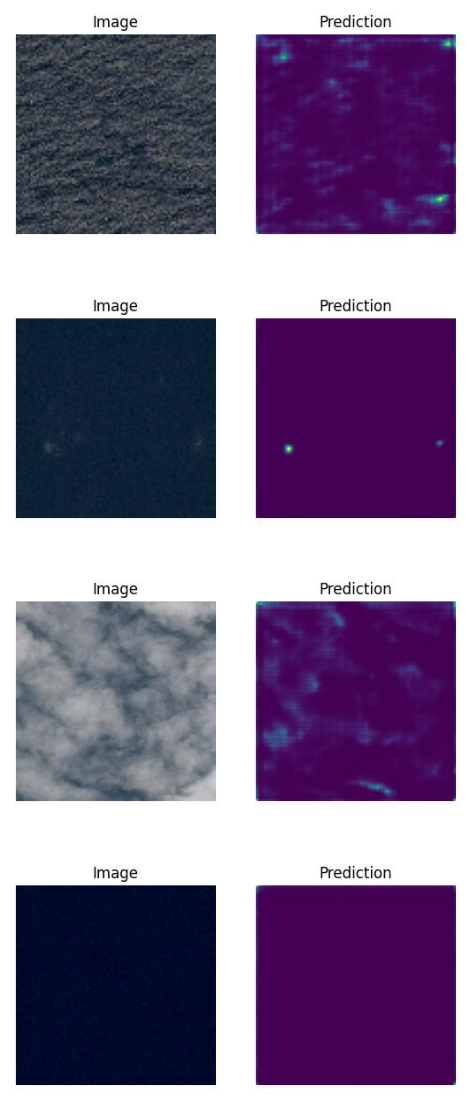

In [72]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
ax1.imshow(mpimg.imread(no_ship_predicted[0]))
ax2.imshow(mpimg.imread(no_ship_predicted[1]))
ax3.imshow(mpimg.imread(no_ship_predicted[2]))
ax4.imshow(mpimg.imread(no_ship_predicted[3]))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
fig.set_size_inches(25, 20)

Predictions on images with ships:

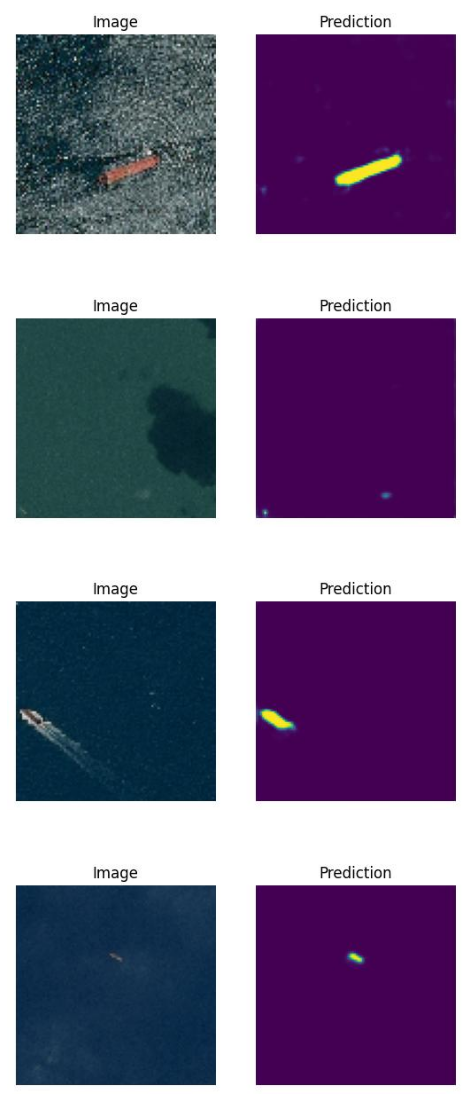

In [73]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
ax1.imshow(mpimg.imread(with_ship_predicted[0]))
ax2.imshow(mpimg.imread(with_ship_predicted[1]))
ax3.imshow(mpimg.imread(with_ship_predicted[2]))
ax4.imshow(mpimg.imread(with_ship_predicted[3]))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
fig.set_size_inches(25, 20)

We can see that model doesn't do really well on models without ships probably due to it's simplicity(Model isn't depp and has only 9k parameters). If it matters a lot we can use deeper model or abandon the downsampling shipless images or use another loss metric. But the model does pretty good on images with boats and that's what I tried to achieve, so I will leave it like that.